In [1]:
import yodo
import numpy as np
import plotly.express as ex
import gc

In [2]:
parser = yodo.XMLParser("./datasets/Ships/")

In [3]:
parser.parse()

In [4]:
parser

XMLParser @ /storage/detect/datasets/Ships

In [77]:
hw = parser.as_dataframe()[['h','w']] * 512

In [78]:
hw.max()

h    431.157895
w    356.957746
dtype: float64

In [6]:
# ex.scatter(data_frame=hw,x='w',y='h')

In [66]:
IMG_SIZE = 512

In [8]:
8 * 32, 4 * 64, 2 * 128

(256, 256, 256)

In [84]:
anchor_config = yodo.utils.JSON({
    "img_size":IMG_SIZE,
    "config":[
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 64, 
                    'k': 9, 
                    'image_size': IMG_SIZE, 
                    'box_gen': {
                        'low': 0, 
                        'high': 96
                    }
                }, 
            'name': 'FPN0'
        }),
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 128, 
                    'k': 5, 
                    'image_size': IMG_SIZE, 
                    'box_gen': {
                        'low': 96, 
                        'high': 192
                    }
                }, 
            'name': 'FPN1'
        }),
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 256, 
                    'k': 3, 
                    'image_size': IMG_SIZE, 
                    'box_gen': {
                        'low': 192, 
                        'high': 384
                    }
                    
                }, 
            'name': 'FPN2'
        }),
    ]
})

In [85]:
anchors = yodo.Anchors(**anchor_config())

In [86]:
y_prob,y_boxes = anchors.encode_batch(parser)

In [87]:
y_prob.shape,y_boxes.shape

((621, 668, 2), (621, 668, 4))

In [88]:
images = yodo.utils.read_images(parser,anchor_config.img_size).astype(np.float32) / 255

In [90]:
gc.collect()

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


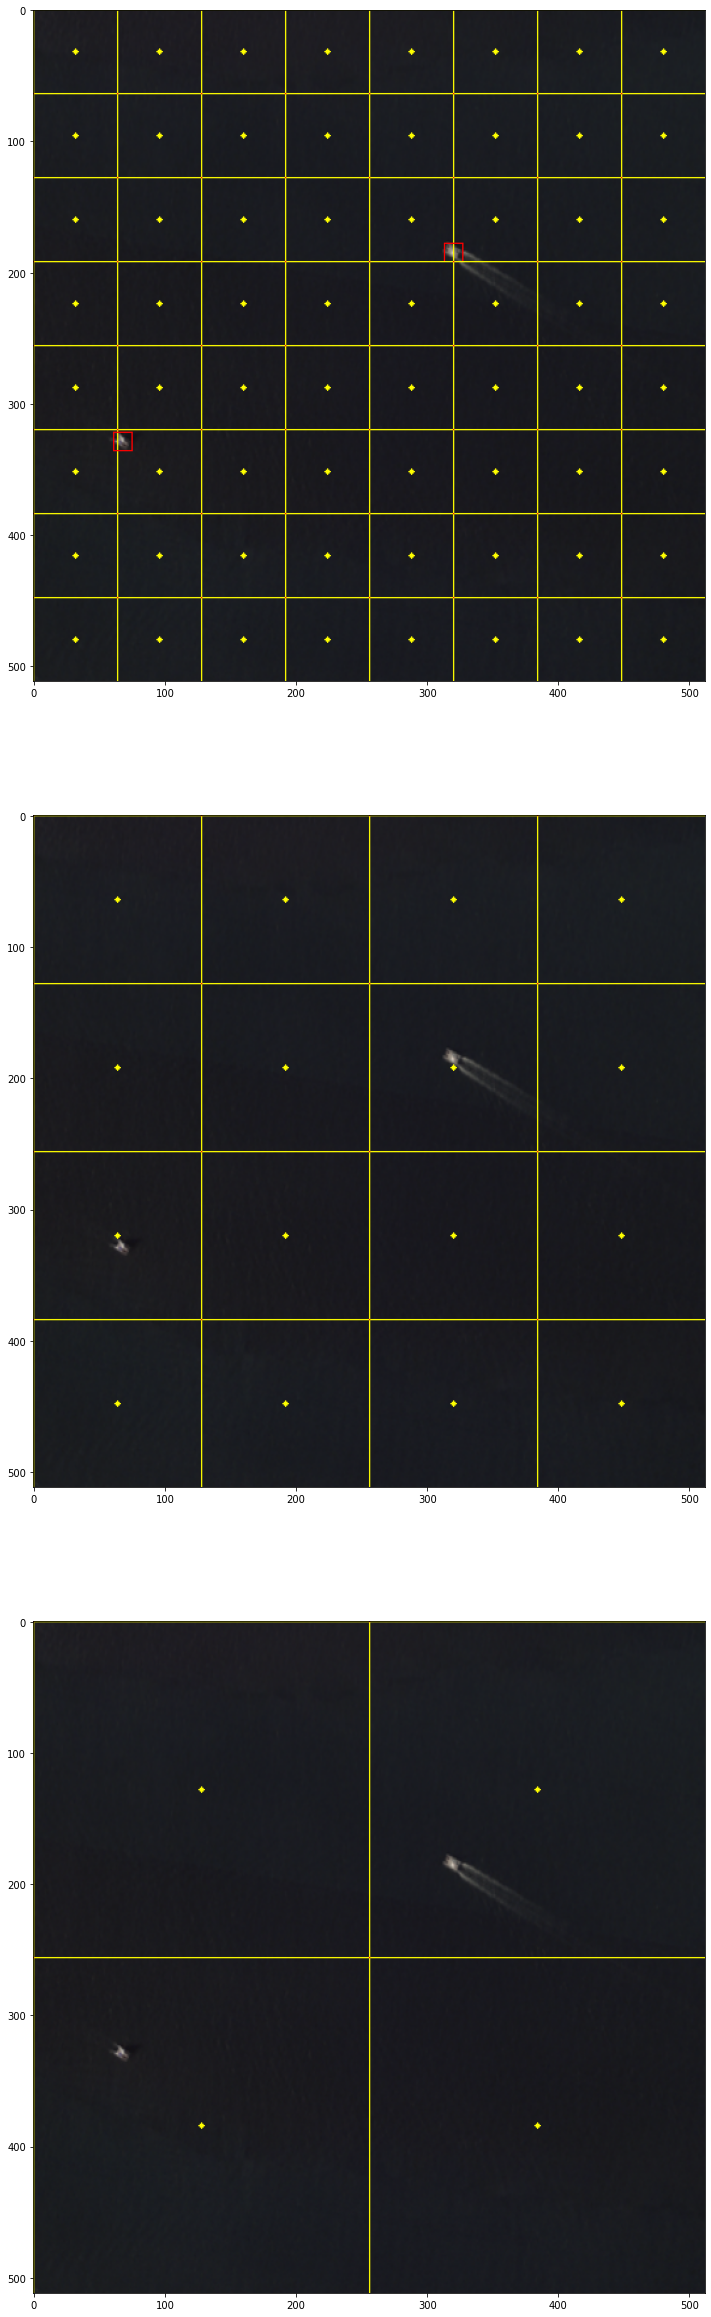

In [93]:
i = np.random.randint(0,len(images))
prob,boxes = anchors.encode(parser[i])
anchors.plot_grid(images[i],prob,boxes)

In [94]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback

In [108]:
config = yodo.utils.JSON({
    "img_size":anchors.img_size,
    "backbone":[
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_a",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_b",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_c",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_d",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":64,
                "ksize":3,
                "name":"block_e",
                "pool":True
            }
        })
    ],
    "proposals":[
        yodo.utils.JSON({
            "k":9,
            "params":{
                "filters":64,
                "ksize":3,
                "name":"opn_0",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "k":5,
            "params":{
                "filters":256,
                "ksize":3,
                "name":"opn_1",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "k":3,
            "params":{
                "filters":1024,
                "ksize":3,
                "name":"opn_2",
                "pool":True
            }
        })
    ]
})

In [109]:
yada = yodo.net.YODO(config=config)

In [110]:
optimizer = keras.optimizers.Adam()

In [111]:
train,test = yodo.net.get_split(len(images),71)

In [112]:
def schedule(epoch):
    if epoch > 5:
        return .0001
    else:
        return .0005
    
lrs = LearningRateScheduler(schedule=schedule,verbose=1)
chk = ModelCheckpoint(filepath="./checkpoints/net_SHIPS",save_weights_only=True,monitor='loss')

In [113]:
yada.build(optimizer=optimizer)

In [114]:
# yada.model.load_weights("./checkpoints/net_SHIPS")

In [115]:
train_flow = yodo.net.flow(300,images,(y_prob,y_boxes),train)

In [116]:
yada.train_generator(train_flow,steps_per_epoch=len(train),epochs=300,callbacks=[lrs,chk])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 1/300
 79/550 [===>..........................] - ETA: 2:45 - loss: 1.7841 - prob_loss: 0.7816 - box_loss: 1.0024

KeyboardInterrupt: 

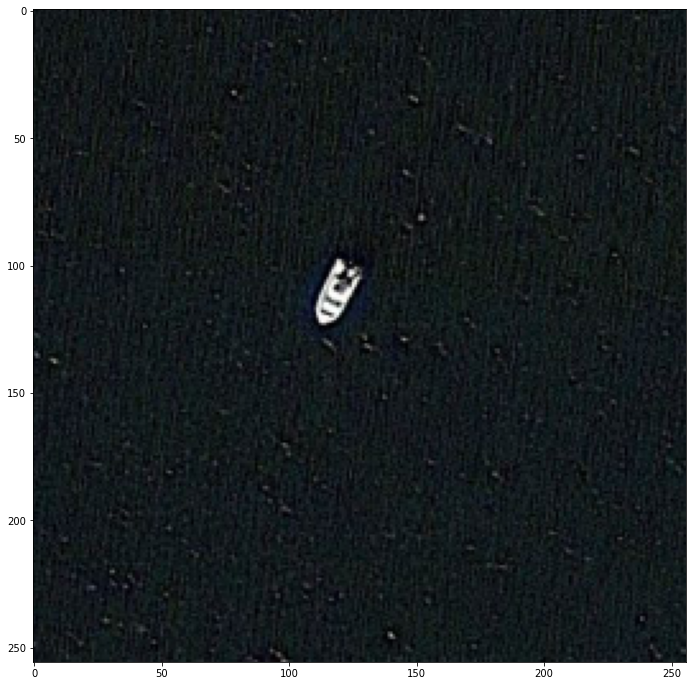

In [81]:
i = np.random.choice(train)
img = images[i].copy()

p,b = yada.model.predict(np.expand_dims(img,0))
boxes = anchors.decode(p,b)

for y,x,h,w in boxes:
    xmin = x - (w//2)
    ymin = y - (h//2)
    
    xmax = x + (w//2)
    ymax = y + (h//2)
    
    img = yodo.cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),1)
    img = yodo.cv2.circle(img,(x,y),2,(255,0,0),-1)
    
yodo.plt.figure(figsize=(12,12))
yodo.plt.imshow(img)